#  MiniVGG models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import drive
drive.mount('/content/drive')

# Dataset folder
dataset_path = "/content/drive/MyDrive/New_Data Set/USTC-TFC_dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Mount Google Drive to access the dataset

import numpy as np
import os # Import os module for file path operations

# Dataset folder (path within your Drive)
dataset_path = "/content/drive/MyDrive/New_Data Set/USTC-TFC_dataset"

# Check if the file exists before attempting to load it
file_path = os.path.join(dataset_path, "x_payload_train.npy")
if os.path.exists(file_path):
    print(f"File found at: {file_path}")
    # Load original hex payloads
    x_train = np.load(file_path, allow_pickle=True)
    x_valid = np.load(os.path.join(dataset_path, "x_payload_valid.npy"), allow_pickle=True)
    x_test  = np.load(os.path.join(dataset_path, "x_payload_test.npy"), allow_pickle=True)
    y_train = np.load(os.path.join(dataset_path, "y_train.npy"))
    y_valid = np.load(os.path.join(dataset_path, "y_valid.npy"))
    y_test  = np.load(os.path.join(dataset_path, "y_test.npy"))

    # Hex to 28x28 grayscale images
    def hex_string_to_byte_array(hex_string, max_len=784):
        hex_string = hex_string.replace(" ", "")
        byte_array = bytes.fromhex(hex_string)
        byte_array = byte_array[:max_len]
        padded = np.zeros(max_len, dtype=np.uint8)
        padded[:len(byte_array)] = list(byte_array)
        return padded

    x_train_proc = np.array([hex_string_to_byte_array(s) for s in x_train])
    x_valid_proc = np.array([hex_string_to_byte_array(s) for s in x_valid])
    x_test_proc  = np.array([hex_string_to_byte_array(s) for s in x_test])

    x_train_img = x_train_proc.reshape(-1, 28, 28, 1) / 255.0
    x_valid_img = x_valid_proc.reshape(-1, 28, 28, 1) / 255.0
    x_test_img  = x_test_proc.reshape(-1, 28, 28, 1) / 255.0
else:
    print(f"Error: File not found at: {file_path}")
    print("Please ensure the file exists and the path is correct.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File found at: /content/drive/MyDrive/New_Data Set/USTC-TFC_dataset/x_payload_train.npy


# Define MiniVGG Model

In [ ]:
# ✅ Imports
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

# ✅ Define Smaller MiniVGG model
def build_minivgg_fast(input_shape=(28, 28, 1), num_classes=20):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ✅ Create model
minivgg_fast = build_minivgg_fast(input_shape=(28, 28, 1), num_classes=20)

# ✅ Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True,
    verbose=1
)

# ✅ Train the model (faster)
history_minivgg_fast = minivgg_fast.fit(
    x_train_img, y_train,
    validation_data=(x_valid_img, y_valid),
    epochs=2,               # ⏱ Reduced for quick testing
    batch_size=32,          # 🚀 Faster batches
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/2
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 92s 37ms/step - accuracy: 0.6050 - loss: 1.1940 - val_accuracy: 0.8950 - val_loss: 0.2859
Epoch 2/2
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 141s 37ms/step - accuracy: 0.8755 - loss: 0.3387 - val_accuracy: 0.9111 - val_loss: 0.2192
Restoring model weights from the end of the best epoch: 2.


304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


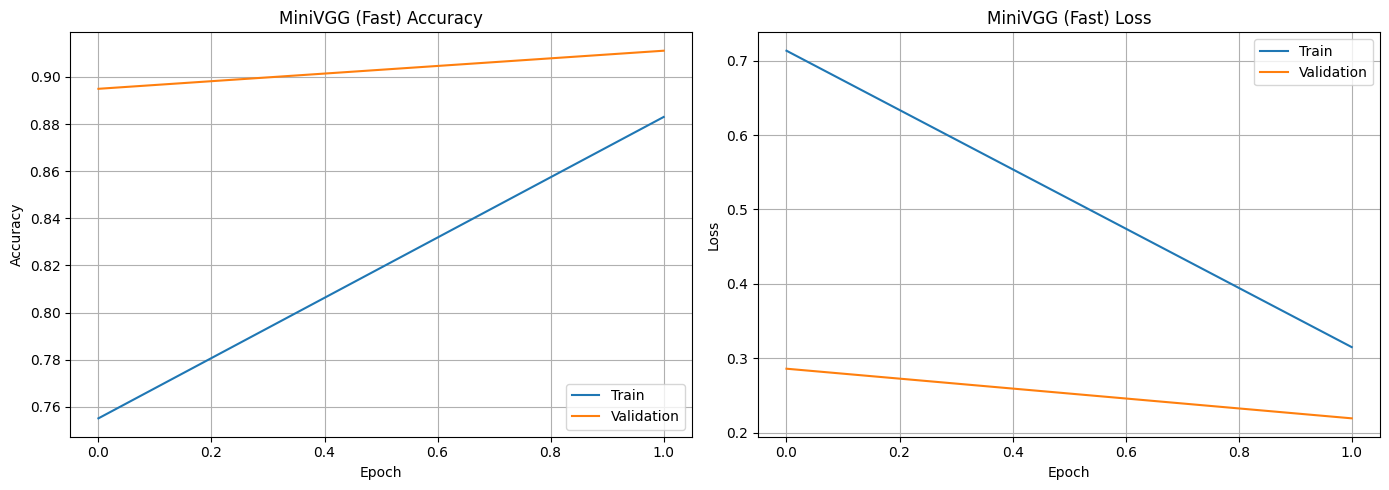

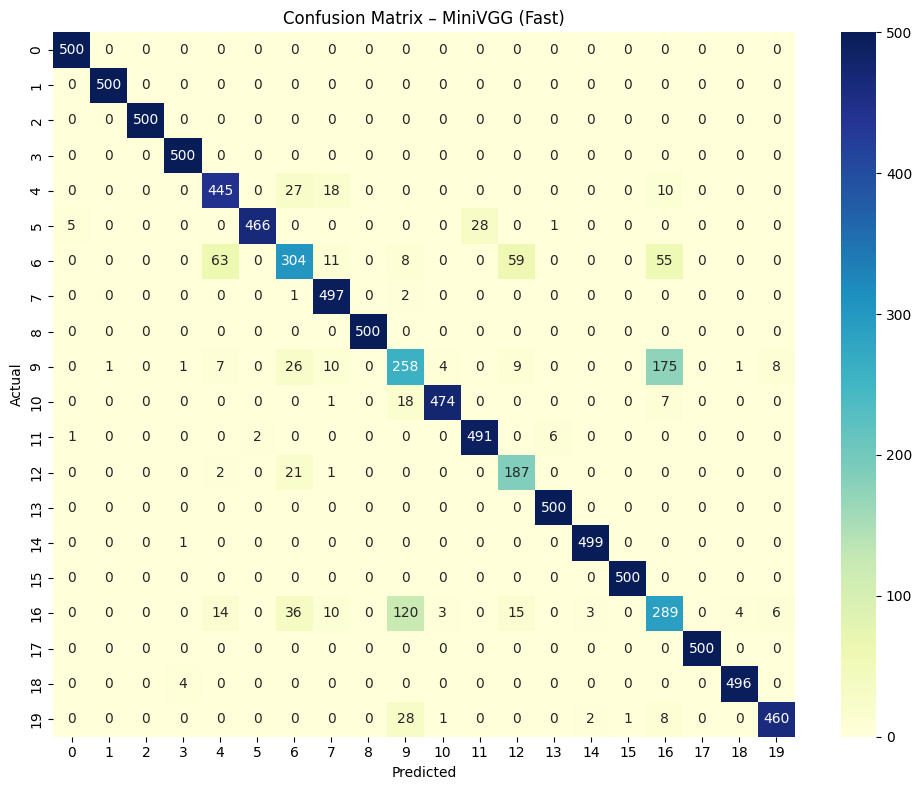

📋 Classification Report – MiniVGG (Fast)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       500
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       500
           3       0.99      1.00      0.99       500
           4       0.84      0.89      0.86       500
           5       1.00      0.93      0.96       500
           6       0.73      0.61      0.66       500
           7       0.91      0.99      0.95       500
           8       1.00      1.00      1.00       500
           9       0.59      0.52      0.55       500
          10       0.98      0.95      0.97       500
          11       0.95      0.98      0.96       500
          12       0.69      0.89      0.78       211
          13       0.99      1.00      0.99       500
          14       0.99      1.00      0.99       500
          15       1.00      1.00      1.00       500
          16       0.53      0.58      0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ Predict on test data
y_pred_fast = np.argmax(minivgg_fast.predict(x_test_img), axis=1)

# ✅ Confusion Matrix
conf_matrix_fast = confusion_matrix(y_test, y_pred_fast)
class_report_fast = classification_report(y_test, y_pred_fast)

# ✅ Accuracy & Loss Plots
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_minivgg_fast.history['accuracy'], label='Train')
plt.plot(history_minivgg_fast.history['val_accuracy'], label='Validation')
plt.title("MiniVGG (Fast) Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_minivgg_fast.history['loss'], label='Train')
plt.plot(history_minivgg_fast.history['val_loss'], label='Validation')
plt.title("MiniVGG (Fast) Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# ✅ Confusion Matrix Plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_fast, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix – MiniVGG (Fast)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ✅ Classification Report
print("📋 Classification Report – MiniVGG (Fast)")
print(class_report_fast)



 Average Augmentation

In [ ]:
# ✅ Imports
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os # Import os module for file path operations
# import bytes # Remove this import, 'bytes' is a built-in data type, not a module

# ✅ Step 1: Define Average Augmentation
def apply_average_augmentation(X, noise_level=0.01):
    noise = np.random.normal(loc=0.0, scale=noise_level, size=X.shape)
    return np.clip(X + noise, 0.0, 1.0)

# Dataset folder (path within your Drive) - you'll need to replace with the actual path if different
dataset_path = "/content/drive/MyDrive/New_Data Set/USTC-TFC_dataset"

# Check if the file exists before attempting to load it
file_path = os.path.join(dataset_path, "x_payload_train.npy")
if os.path.exists(file_path):
    print(f"File found at: {file_path}")
    # Load original hex payloads
    x_train = np.load(file_path, allow_pickle=True)
    x_valid = np.load(os.path.join(dataset_path, "x_payload_valid.npy"), allow_pickle=True)
    x_test  = np.load(os.path.join(dataset_path, "x_payload_test.npy"), allow_pickle=True)
    y_train = np.load(os.path.join(dataset_path, "y_train.npy"))
    y_valid = np.load(os.path.join(dataset_path, "y_valid.npy"))
    y_test  = np.load(os.path.join(dataset_path, "y_test.npy"))

    # Hex to 28x28 grayscale images
    def hex_string_to_byte_array(hex_string, max_len=784):
        hex_string = hex_string.replace(" ", "")
        byte_array = bytes.fromhex(hex_string) # bytes.fromhex is the correct usage
        byte_array = byte_array[:max_len]
        padded = np.zeros(max_len, dtype=np.uint8)
        padded[:len(byte_array)] = list(byte_array)
        return padded

    x_train_proc = np.array([hex_string_to_byte_array(s) for s in x_train])
    x_valid_proc = np.array([hex_string_to_byte_array(s) for s in x_valid])
    x_test_proc  = np.array([hex_string_to_byte_array(s) for s in x_test])

    x_train_img = x_train_proc.reshape(-1, 28, 28, 1) / 255.0
    x_valid_img = x_valid_proc.reshape(-1, 28, 28, 1) / 255.0
    x_test_img  = x_test_proc.reshape(-1, 28, 28, 1) / 255.0
else:
    print(f"Error: File not found at: {file_path}")
    print("Please ensure the file exists and the path is correct.")

x_train_avg = apply_average_augmentation(x_train_img)
x_val_avg   = apply_average_augmentation(x_valid_img)
x_test_avg  = apply_average_augmentation(x_test_img)


# ✅ Step 2: Reuse the MiniVGG Fast model builder
def build_minivgg_fast(input_shape=(28, 28, 1), num_classes=20):
    from tensorflow.keras import models, layers
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ✅ Step 3: Train MiniVGG Fast on Augmented Data
minivgg_avg = build_minivgg_fast(input_shape=(28, 28, 1), num_classes=20)

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True, verbose=1)

history_avg = minivgg_avg.fit(
    x_train_avg, y_train,
    validation_data=(x_val_avg, y_valid),
    epochs=3,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

File found at: /content/drive/MyDrive/New_Data Set/USTC-TFC_dataset/x_payload_train.npy
Epoch 1/3
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 98s 39ms/step - accuracy: 0.5635 - loss: 1.3095 - val_accuracy: 0.8748 - val_loss: 0.3376
Epoch 2/3
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 142s 39ms/step - accuracy: 0.8466 - loss: 0.4181 - val_accuracy: 0.9032 - val_loss: 0.2536
Epoch 3/3
2428/2428 ━━━━━━━━━━━━━━━━━━━━ 138s 38ms/step - accuracy: 0.8771 - loss: 0.3233 - val_accuracy: 0.9152 - val_loss: 0.2198
Restoring model weights from the end of the best epoch: 3.


#  Evaluate + Visualize

304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


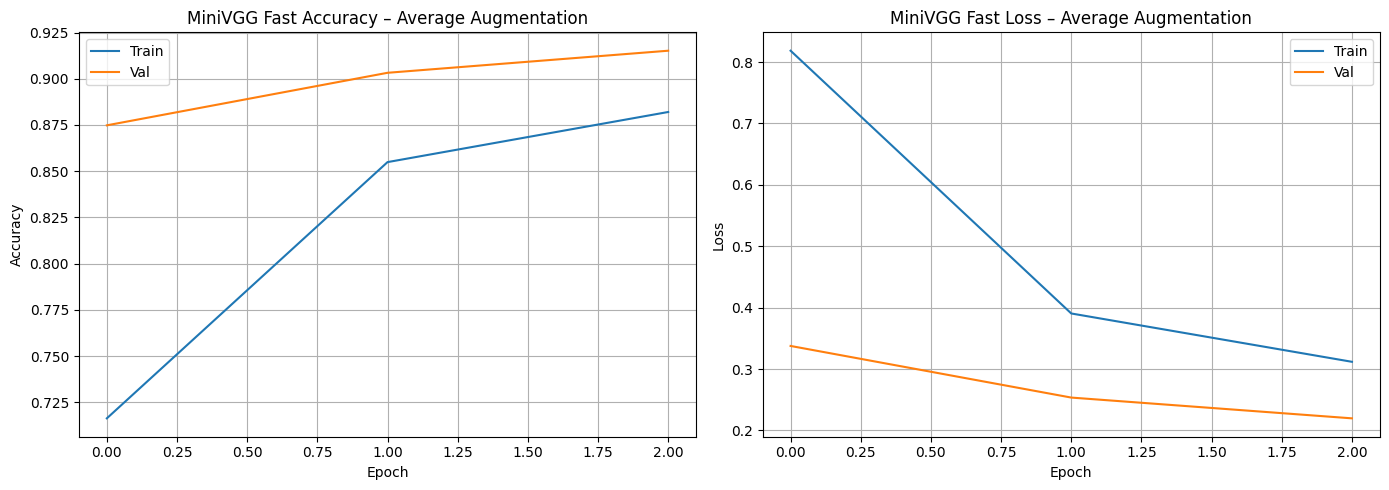

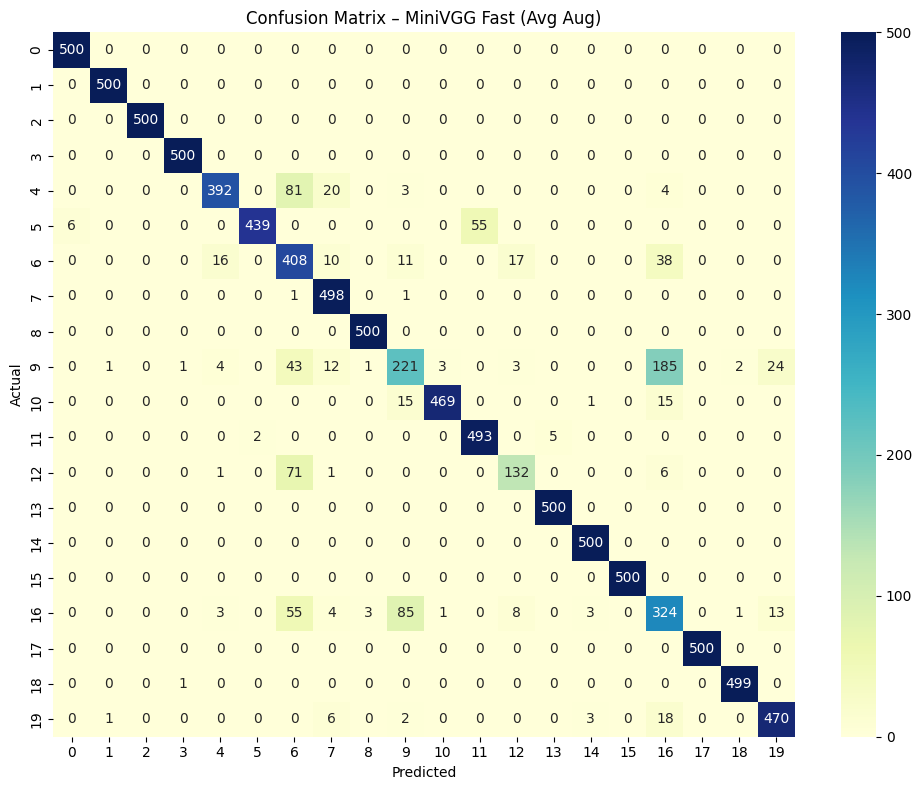

📋 Classification Report – MiniVGG Fast (Average Augmentation)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       500
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       500
           3       1.00      1.00      1.00       500
           4       0.94      0.78      0.86       500
           5       1.00      0.88      0.93       500
           6       0.62      0.82      0.70       500
           7       0.90      1.00      0.95       500
           8       0.99      1.00      1.00       500
           9       0.65      0.44      0.53       500
          10       0.99      0.94      0.96       500
          11       0.90      0.99      0.94       500
          12       0.82      0.63      0.71       211
          13       0.99      1.00      1.00       500
          14       0.99      1.00      0.99       500
          15       1.00      1.00      1.00       500
          16       

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ Predict and Evaluate
y_pred_avg = np.argmax(minivgg_avg.predict(x_test_avg), axis=1)
conf_matrix_avg = confusion_matrix(y_test, y_pred_avg)
class_report_avg = classification_report(y_test, y_pred_avg)

# ✅ Plot Accuracy & Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_avg.history['accuracy'], label='Train')
plt.plot(history_avg.history['val_accuracy'], label='Val')
plt.title("MiniVGG Fast Accuracy – Average Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_avg.history['loss'], label='Train')
plt.plot(history_avg.history['val_loss'], label='Val')
plt.title("MiniVGG Fast Loss – Average Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Plot Confusion Matrix with class labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_avg, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix – MiniVGG Fast (Avg Aug)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ✅ Classification Report
print("📋 Classification Report – MiniVGG Fast (Average Augmentation)")
print(class_report_avg)


2428/2428 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


<ipython-input-36-74a03794a3a5>:52: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


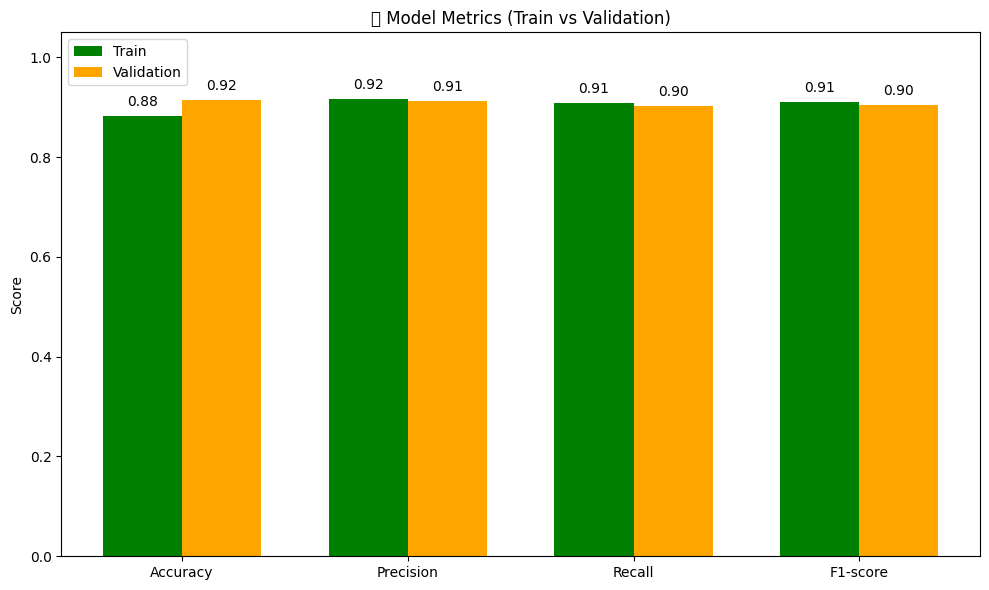

In [36]:
# ✅ Step 1: Calculate Metrics
# Import necessary functions
from sklearn.metrics import precision_score, recall_score, f1_score # Import precision_score

# Get the predictions for both training and testing data
y_train_pred = minivgg_avg.predict(x_train_avg)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = y_train

y_test_pred = minivgg_avg.predict(x_test_avg)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = y_test

# Compute metrics
train_accuracy = history_avg.history['accuracy'][-1]
val_accuracy = history_avg.history['val_accuracy'][-1]

train_precision = precision_score(y_train_true_classes, y_train_pred_classes, average='macro')
val_precision = precision_score(y_test_true_classes, y_test_pred_classes, average='macro')

train_recall = recall_score(y_train_true_classes, y_train_pred_classes, average='macro')
val_recall = recall_score(y_test_true_classes, y_test_pred_classes, average='macro')

train_f1 = f1_score(y_train_true_classes, y_train_pred_classes, average='macro')
val_f1 = f1_score(y_test_true_classes, y_test_pred_classes, average='macro')

# ✅ Step 2: Create the Bar Chart for Accuracy, Precision, Recall, and F1-Score
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
val_scores = [val_accuracy, val_precision, val_recall, val_f1]

x = np.arange(len(metrics_labels))  # X-axis labels
width = 0.35  # Width of the bars

# Create the plot
plt.figure(figsize=(10, 6))
bar1 = plt.bar(x - width/2, train_scores, width, label='Train', color='green')
bar2 = plt.bar(x + width/2, val_scores, width, label='Validation', color='orange')

# Adding labels and title
plt.ylabel('Score')
plt.title('📊 Model Metrics (Train vs Validation)')
plt.xticks(x, metrics_labels)
plt.ylim(0, 1.05)
plt.legend()

# Add value labels on top of the bars
for bar in bar1 + bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Define MTU Augmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Dataset folder
dataset_path = "/content/drive/MyDrive/USTC-TFC_dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np

dataset_path = "/content/drive/MyDrive/New_Data Set/USTC-TFC_dataset"

# ✅ Actual number of samples (based on previous info)
num_train = 77692
num_valid = 9712
num_test  = 9711

# ✅ Load 1D-flattened arrays
x_train_raw = np.load(f"{dataset_path}/x_payload_train.npy")
x_valid_raw = np.load(f"{dataset_path}/x_payload_valid.npy")
x_test_raw  = np.load(f"{dataset_path}/x_payload_test.npy")

y_train = np.load(f"{dataset_path}/y_train.npy")
y_valid = np.load(f"{dataset_path}/y_valid.npy")
y_test  = np.load(f"{dataset_path}/y_test.npy")

# ✅ Infer feature count
feature_count = int(len(x_train_raw) / num_train)

# ✅ Reshape to (samples, features)
x_train_raw = x_train_raw.reshape((num_train, feature_count))
x_valid_raw = x_valid_raw.reshape((num_valid, feature_count))
x_test_raw  = x_test_raw.reshape((num_test,  feature_count))


In [ ]:
import numpy as np

# Load hex-encoded payload array
x_train_hex = np.load("/content/drive/MyDrive/New_Data Set/USTC-TFC_dataset/x_payload_train.npy", allow_pickle=True)

# Convert each hex string → list of byte values (0–255)
def hex_to_bytes_vector(hex_str, max_len=784):
    hex_str = hex_str.replace(" ", "")  # remove spaces
    bytes_array = [int(hex_str[i:i+2], 16) for i in range(0, len(hex_str), 2)]
    # Pad/crop to fixed length
    if len(bytes_array) < max_len:
        bytes_array += [0] * (max_len - len(bytes_array))
    else:
        bytes_array = bytes_array[:max_len]
    return np.array(bytes_array, dtype=np.uint8)

# Convert all samples
x_train_fixed = np.array([hex_to_bytes_vector(x) for x in x_train_hex])

# Reshape to image format
x_train_img15 = x_train_fixed.reshape(-1, 28, 28, 1) / 255.0

# ✅ Save
np.save("/content/drive/MyDrive/New_Data Set/USTC-TFC_dataset/x_train_img15.npy", x_train_img15)
print("✅ x_train_img15 generated and saved!")


✅ x_train_img15 generated and saved!


In [ ]:
import numpy as np

dataset_path = "/content/drive/MyDrive/New_Data Set/USTC-TFC_dataset"

# ✅ Load hex payload arrays
x_train_hex = np.load(f"{dataset_path}/x_payload_train.npy", allow_pickle=True)
x_valid_hex = np.load(f"{dataset_path}/x_payload_valid.npy", allow_pickle=True)
x_test_hex  = np.load(f"{dataset_path}/x_payload_test.npy",  allow_pickle=True)

# ✅ Convert hex string to fixed-length byte array
def hex_to_bytes_vector(hex_str, max_len=784):
    hex_str = hex_str.replace(" ", "")  # Remove spaces
    bytes_array = [int(hex_str[i:i+2], 16) for i in range(0, len(hex_str), 2)]
    if len(bytes_array) < max_len:
        bytes_array += [0] * (max_len - len(bytes_array))
    else:
        bytes_array = bytes_array[:max_len]
    return np.array(bytes_array, dtype=np.uint8)

# ✅ Convert all 3 sets
def convert_hex_array(hex_array, name):
    print(f"Converting {name} ...")
    byte_matrix = np.array([hex_to_bytes_vector(x) for x in hex_array])
    img_data = byte_matrix.reshape(-1, 28, 28, 1) / 255.0
    save_path = f"{dataset_path}/{name}.npy"
    np.save(save_path, img_data)
    print(f"✅ Saved: {save_path}")
    return img_data

x_train_img15 = convert_hex_array(x_train_hex, "x_train_img15")
x_valid_img15 = convert_hex_array(x_valid_hex, "x_valid_img15")
x_test_img15  = convert_hex_array(x_test_hex,  "x_test_img15")


Converting x_train_img15 ...
✅ Saved: /content/drive/MyDrive/New_Data Set/USTC-TFC_dataset/x_train_img15.npy
Converting x_valid_img15 ...
✅ Saved: /content/drive/MyDrive/New_Data Set/USTC-TFC_dataset/x_valid_img15.npy
Converting x_test_img15 ...
✅ Saved: /content/drive/MyDrive/New_Data Set/USTC-TFC_dataset/x_test_img15.npy


In [ ]:
import numpy as np

dataset_path = "/content/drive/MyDrive/New_Data Set/USTC-TFC_dataset"

x_train_img15 = np.load(f"{dataset_path}/x_train_img15.npy")
x_valid_img15 = np.load(f"{dataset_path}/x_valid_img15.npy")
x_test_img15  = np.load(f"{dataset_path}/x_test_img15.npy")

y_train = np.load(f"{dataset_path}/y_train.npy")
y_valid = np.load(f"{dataset_path}/y_valid.npy")
y_test  = np.load(f"{dataset_path}/y_test.npy")


In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

def build_minivgg_fast(input_shape=(28, 28, 1), num_classes=20):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
minivgg_model = build_minivgg_fast(input_shape=(28, 28, 1), num_classes=len(np.unique(y_train)))

early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True, verbose=1)

history = minivgg_model.fit(
    x_train_img15, y_train,
    validation_data=(x_valid_img15, y_valid),
    epochs=3,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/3
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.4951 - loss: 1.5527 - val_accuracy: 0.8844 - val_loss: 0.3525
Epoch 2/3
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 84s 69ms/step - accuracy: 0.8336 - loss: 0.4675 - val_accuracy: 0.9030 - val_loss: 0.2570
Epoch 3/3
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 141s 69ms/step - accuracy: 0.8686 - loss: 0.3567 - val_accuracy: 0.9172 - val_loss: 0.2233
Restoring model weights from the end of the best epoch: 3.


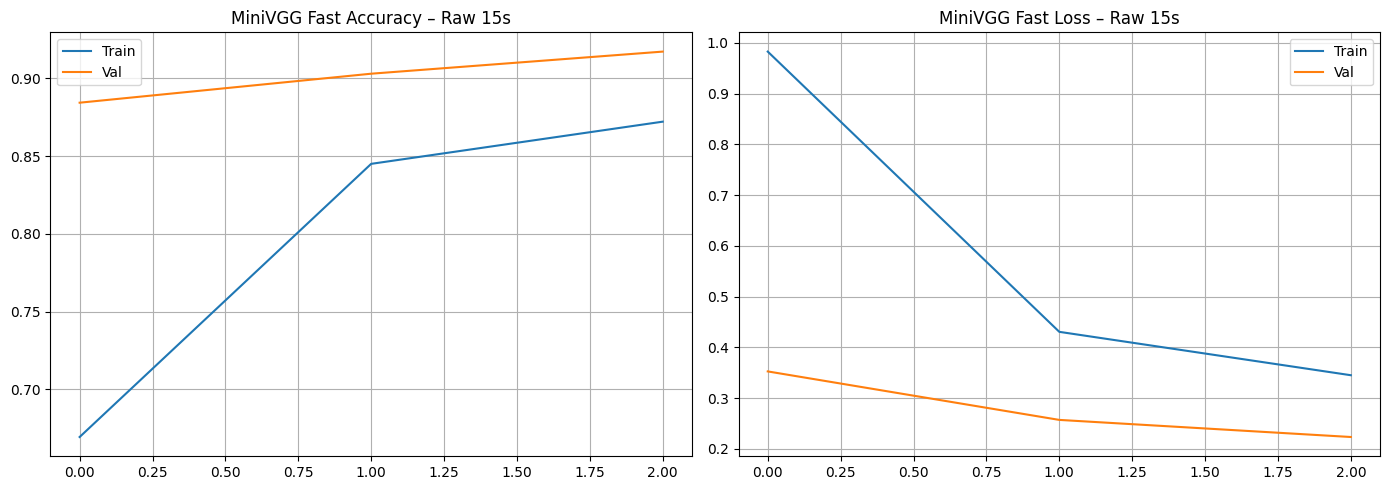

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("MiniVGG Fast Accuracy – Raw 15s")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("MiniVGG Fast Loss – Raw 15s")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# MTU Augmentation + MiniVGG Fast

2428/2428 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


<ipython-input-38-870030fce77d>:53: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


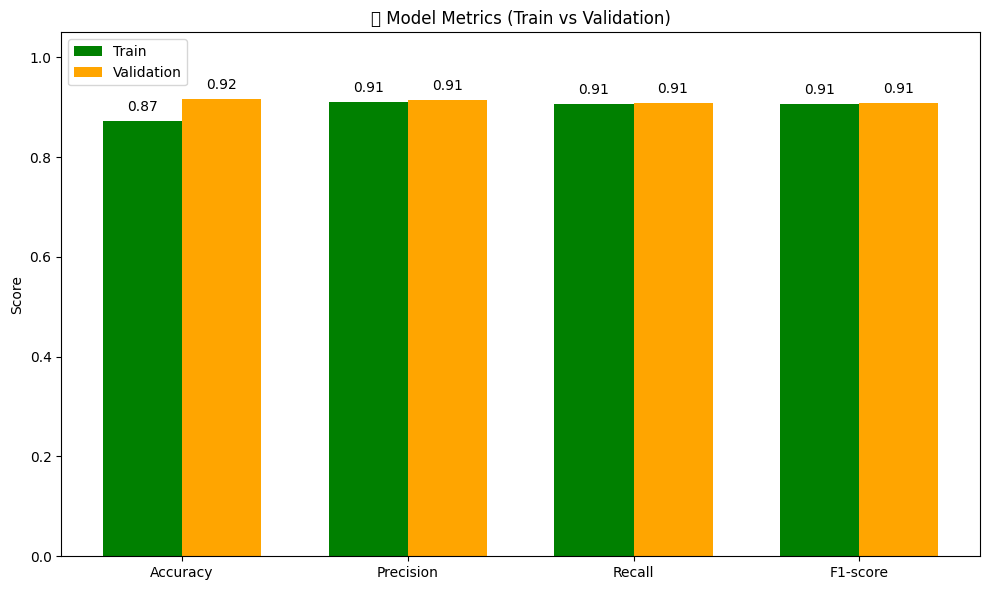

In [38]:
# Step 1: Get predictions
# Get predictions for training set
y_train_pred = minivgg_model.predict(x_train_img15)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
# The y_train is already a 1-d array of labels.
# This is consistent with the sparse_categorical_crossentropy loss.
y_train_true_classes = y_train

# Get predictions for validation set
y_valid_pred = minivgg_model.predict(x_valid_img15)
y_valid_pred_classes = np.argmax(y_valid_pred, axis=1)
# The y_valid is already a 1-d array of labels.
# This is consistent with the sparse_categorical_crossentropy loss.
y_valid_true_classes = y_valid
# Step 2: Compute metrics
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

train_precision = precision_score(y_train_true_classes, y_train_pred_classes, average='macro')
val_precision = precision_score(y_valid_true_classes, y_valid_pred_classes, average='macro')

train_recall = recall_score(y_train_true_classes, y_train_pred_classes, average='macro')
val_recall = recall_score(y_valid_true_classes, y_valid_pred_classes, average='macro')

train_f1 = f1_score(y_train_true_classes, y_train_pred_classes, average='macro')
val_f1 = f1_score(y_valid_true_classes, y_valid_pred_classes, average='macro')

# Step 3: Bar chart
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
val_scores = [val_accuracy, val_precision, val_recall, val_f1]

x = np.arange(len(metrics_labels))
width = 0.35

# Create the bar chart
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, train_scores, width, label='Train', color='green')
bars2 = plt.bar(x + width/2, val_scores, width, label='Validation', color='orange')

# Add labels and title
plt.ylabel('Score')
plt.title('📊 Model Metrics (Train vs Validation)')
plt.xticks(x, metrics_labels)
plt.ylim(0, 1.05)
plt.legend()

# Add value annotations on top of the bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


In [39]:
import numpy as np

dataset_path = "/content/drive/MyDrive/New_Data Set/USTC-TFC_dataset"

x_train_img15 = np.load(f"{dataset_path}/x_train_img15.npy")
x_valid_img15 = np.load(f"{dataset_path}/x_valid_img15.npy")
x_test_img15  = np.load(f"{dataset_path}/x_test_img15.npy")

y_train = np.load(f"{dataset_path}/y_train.npy")
y_valid = np.load(f"{dataset_path}/y_valid.npy")
y_test  = np.load(f"{dataset_path}/y_test.npy")


# Apply MTU Augmentation

In [ ]:
def apply_mtu_augmentation(X, dropout_rate=0.15, noise_scale=0.05):
    mask = np.random.binomial(1, 1 - dropout_rate, size=X.shape)
    noise = np.random.normal(0.0, noise_scale, size=X.shape)
    return np.clip(X * mask + noise, 0.0, 1.0)

x_train_mtu15 = apply_mtu_augmentation(x_train_img15)
x_valid_mtu15 = apply_mtu_augmentation(x_valid_img15)
x_test_mtu15  = apply_mtu_augmentation(x_test_img15)


# Train MiniVGG Fast on MTU Data

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

def build_minivgg_fast(input_shape=(28, 28, 1), num_classes=20):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model_mtu = build_minivgg_fast(input_shape=(28, 28, 1), num_classes=len(np.unique(y_train)))

early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True, verbose=1)

history_mtu = model_mtu.fit(
    x_train_mtu15, y_train,
    validation_data=(x_valid_mtu15, y_valid),
    epochs=3,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/3
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 88s 71ms/step - accuracy: 0.4747 - loss: 1.5918 - val_accuracy: 0.8198 - val_loss: 0.5121
Epoch 2/3
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 85s 70ms/step - accuracy: 0.7905 - loss: 0.5922 - val_accuracy: 0.8684 - val_loss: 0.3743
Epoch 3/3
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 143s 71ms/step - accuracy: 0.8289 - loss: 0.4782 - val_accuracy: 0.8754 - val_loss: 0.3434
Restoring model weights from the end of the best epoch: 3.


# Visualize Accuracy & Loss

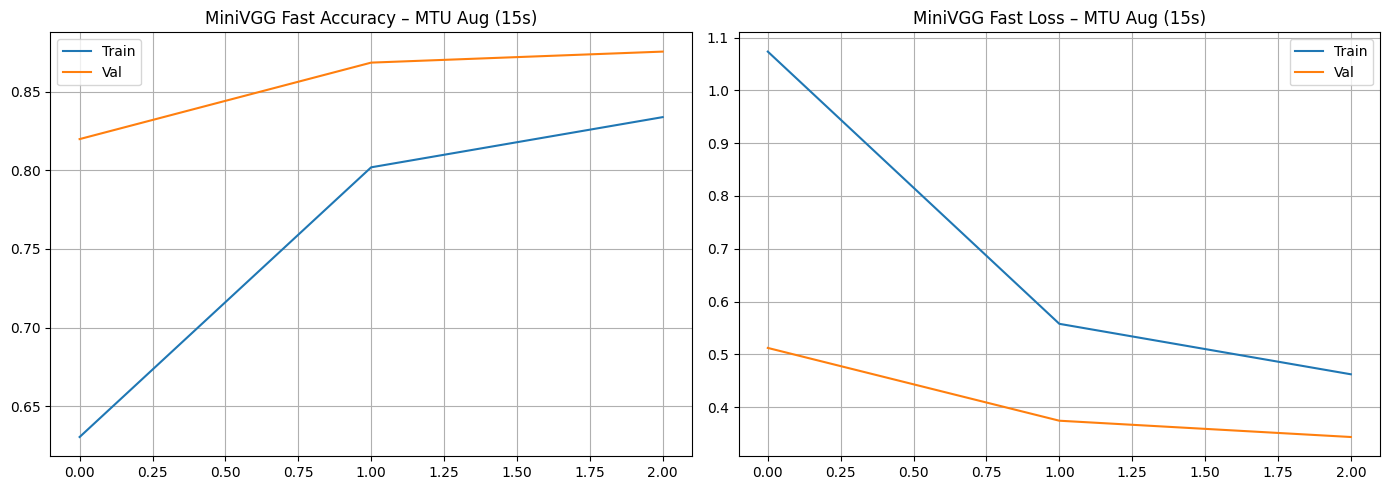

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_mtu.history['accuracy'], label='Train')
plt.plot(history_mtu.history['val_accuracy'], label='Val')
plt.title("MiniVGG Fast Accuracy – MTU Aug (15s)")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mtu.history['loss'], label='Train')
plt.plot(history_mtu.history['val_loss'], label='Val')
plt.title("MiniVGG Fast Loss – MTU Aug (15s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


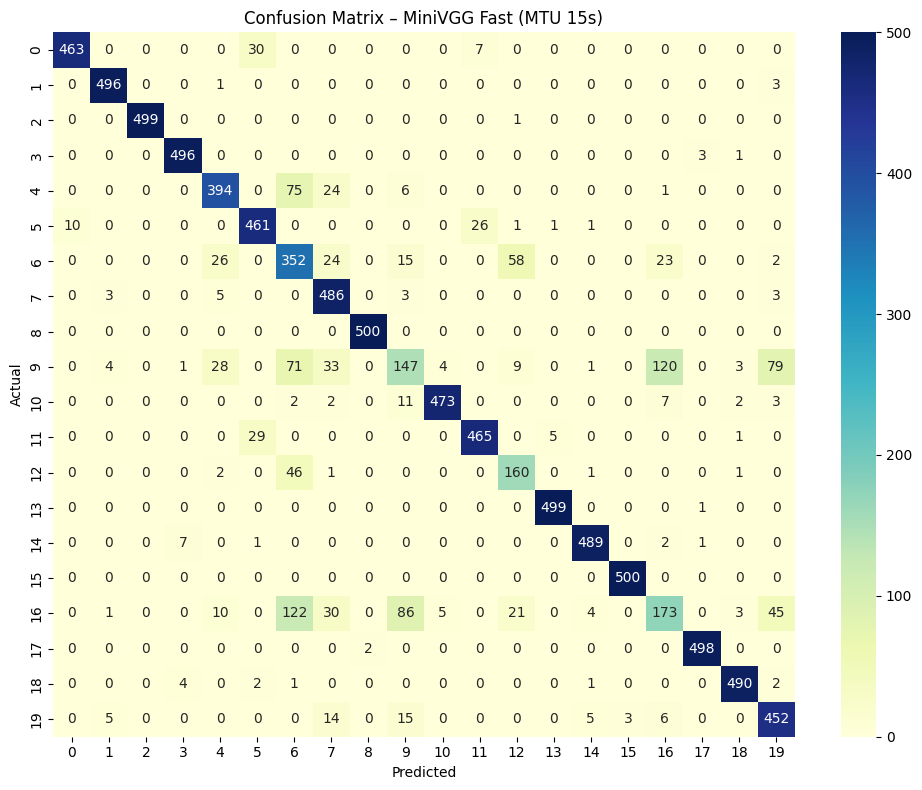

📋 Classification Report – MiniVGG Fast (MTU 15s)
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       500
           1       0.97      0.99      0.98       500
           2       1.00      1.00      1.00       500
           3       0.98      0.99      0.98       500
           4       0.85      0.79      0.82       500
           5       0.88      0.92      0.90       500
           6       0.53      0.70      0.60       500
           7       0.79      0.97      0.87       500
           8       1.00      1.00      1.00       500
           9       0.52      0.29      0.38       500
          10       0.98      0.95      0.96       500
          11       0.93      0.93      0.93       500
          12       0.64      0.76      0.69       211
          13       0.99      1.00      0.99       500
          14       0.97      0.98      0.98       500
          15       0.99      1.00      1.00       500
          16       0.52      0.3

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_mtu = np.argmax(model_mtu.predict(x_test_mtu15), axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_mtu), annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix – MiniVGG Fast (MTU 15s)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("📋 Classification Report – MiniVGG Fast (MTU 15s)")
print(classification_report(y_test, y_pred_mtu))


2428/2428 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


<ipython-input-41-84090e0f0564>:54: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


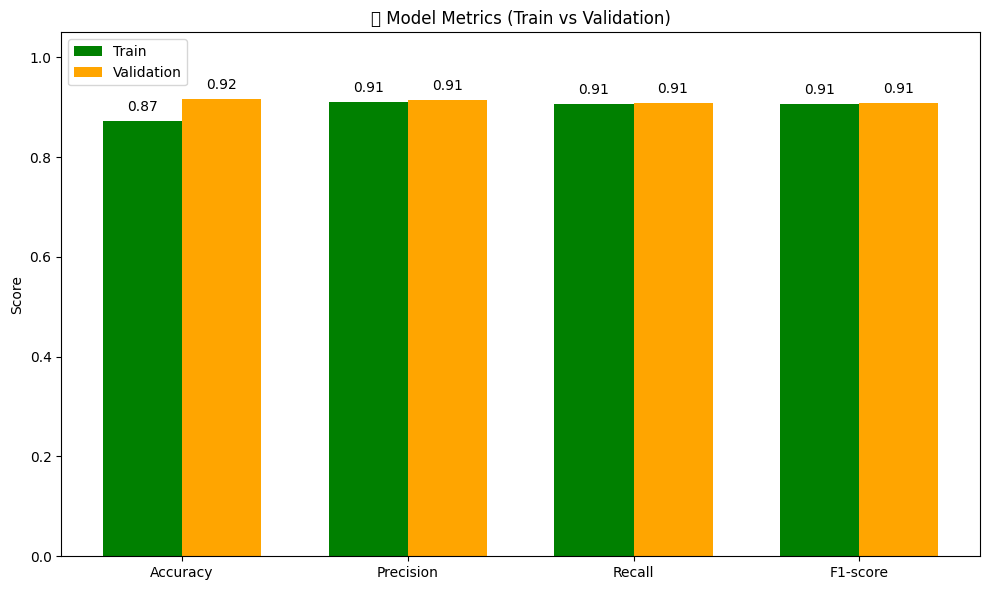

In [41]:
# Step 1: Get predictions
# Get predictions for training set
y_train_pred = minivgg_model.predict(x_train_img15)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
# The y_train is already a 1-d array of labels.
# This is consistent with the sparse_categorical_crossentropy loss.
y_train_true_classes = y_train

# Get predictions for validation set
y_valid_pred = minivgg_model.predict(x_valid_img15)
y_valid_pred_classes = np.argmax(y_valid_pred, axis=1)
# The y_valid is already a 1-d array of labels.
# This is consistent with the sparse_categorical_crossentropy loss.
y_valid_true_classes = y_valid

# Step 2: Compute metrics
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

train_precision = precision_score(y_train_true_classes, y_train_pred_classes, average='macro')
val_precision = precision_score(y_valid_true_classes, y_valid_pred_classes, average='macro')

train_recall = recall_score(y_train_true_classes, y_train_pred_classes, average='macro')
val_recall = recall_score(y_valid_true_classes, y_valid_pred_classes, average='macro')

train_f1 = f1_score(y_train_true_classes, y_train_pred_classes, average='macro')
val_f1 = f1_score(y_valid_true_classes, y_valid_pred_classes, average='macro')

# Step 3: Bar chart
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
val_scores = [val_accuracy, val_precision, val_recall, val_f1]

x = np.arange(len(metrics_labels))
width = 0.35

# Create the bar chart
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, train_scores, width, label='Train', color='green')
bars2 = plt.bar(x + width/2, val_scores, width, label='Validation', color='orange')

# Add labels and title
plt.ylabel('Score')
plt.title('📊 Model Metrics (Train vs Validation)')
plt.xticks(x, metrics_labels)
plt.ylim(0, 1.05)
plt.legend()

# Add value annotations on top of the bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# MiniVGG Fast – Without Augmentation (Raw 15s)

In [ ]:
import numpy as np

dataset_path = "/content/drive/MyDrive/New_Data Set/USTC-TFC_dataset"

x_train_img15 = np.load(f"{dataset_path}/x_train_img15.npy")
x_valid_img15 = np.load(f"{dataset_path}/x_valid_img15.npy")
x_test_img15  = np.load(f"{dataset_path}/x_test_img15.npy")

y_train = np.load(f"{dataset_path}/y_train.npy")
y_valid = np.load(f"{dataset_path}/y_valid.npy")
y_test  = np.load(f"{dataset_path}/y_test.npy")


# Build MiniVGG Fast Model

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

def build_minivgg_fast(input_shape=(28, 28, 1), num_classes=20):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# Train Without Augmentation (Raw)

In [ ]:
model_raw = build_minivgg_fast(input_shape=(28, 28, 1), num_classes=len(np.unique(y_train)))

early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True, verbose=1)

history_raw = model_raw.fit(
    x_train_img15, y_train,
    validation_data=(x_valid_img15, y_valid),
    epochs=3,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/3
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 89s 71ms/step - accuracy: 0.4712 - loss: 1.5919 - val_accuracy: 0.8619 - val_loss: 0.4129
Epoch 2/3
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 85s 70ms/step - accuracy: 0.7981 - loss: 0.5616 - val_accuracy: 0.8913 - val_loss: 0.2917
Epoch 3/3
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 140s 68ms/step - accuracy: 0.8372 - loss: 0.4366 - val_accuracy: 0.9004 - val_loss: 0.2576
Restoring model weights from the end of the best epoch: 3.


# Accuracy & Loss Plot (Raw)

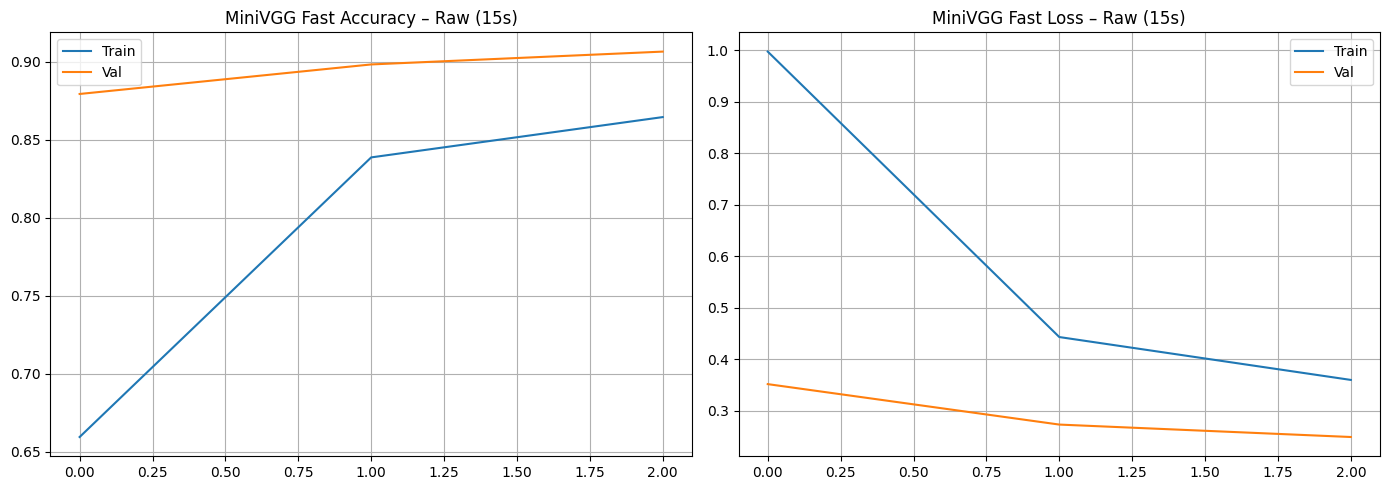

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_raw.history['accuracy'], label='Train')
plt.plot(history_raw.history['val_accuracy'], label='Val')
plt.title("MiniVGG Fast Accuracy – Raw (15s)")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_raw.history['loss'], label='Train')
plt.plot(history_raw.history['val_loss'], label='Val')
plt.title("MiniVGG Fast Loss – Raw (15s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Without Aug

Epoch 1/10
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 46s 36ms/step - accuracy: 0.3897 - loss: 1.8475 - val_accuracy: 0.8169 - val_loss: 0.5845
Epoch 2/10
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.7138 - loss: 0.7781 - val_accuracy: 0.8730 - val_loss: 0.3832
Epoch 3/10
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.7717 - loss: 0.6253 - val_accuracy: 0.8777 - val_loss: 0.3260
Epoch 4/10
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.7959 - loss: 0.5474 - val_accuracy: 0.8894 - val_loss: 0.2958
Epoch 5/10
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.8107 - loss: 0.5062 - val_accuracy: 0.8929 - val_loss: 0.2799
Epoch 6/10
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 81s 36ms/step - accuracy: 0.8208 - loss: 0.4763 - val_accuracy: 0.8986 - val_loss: 0.2614
Epoch 7/10
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 45s 37ms/step - accuracy: 0.8289 - loss: 0.4502 - val_accuracy: 0.8919 - val_loss: 0.2531
Epoch 8/10
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.8361 -

<ipython-input-44-4589649b5f92>:90: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


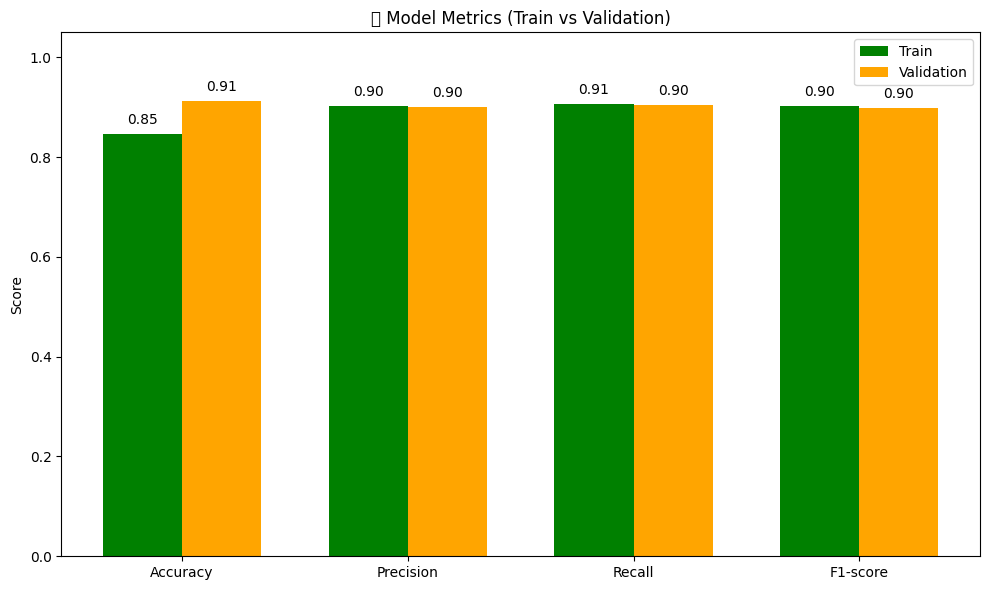

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# ✅ Step 1: Define a simplified MiniVGG model
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

def build_minivgg_fast(input_shape=(28, 28, 1), num_classes=20):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),  # Increased dropout to 50% to prevent overfitting
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and compile the model with reduced complexity
model_raw = build_minivgg_fast(input_shape=(28, 28, 1), num_classes=len(np.unique(y_train)))

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

# ✅ Step 2: Train the model
history_raw = model_raw.fit(
    x_train_img15, y_train,
    validation_data=(x_valid_img15, y_valid),
    epochs=10,  # Train for more epochs to observe the effect of regularization
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# ✅ Step 3: Evaluate the model
test_loss, test_acc = model_raw.evaluate(x_test_img15, y_test)
print(f"Test Accuracy (Reduced Model): {test_acc:.4f}")

# ✅ Step 4: Get predictions for the training and test data
y_train_pred = model_raw.predict(x_train_img15)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = y_train

y_test_pred = model_raw.predict(x_test_img15)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = y_test

# ✅ Step 5: Compute metrics for train and test data
train_accuracy = history_raw.history['accuracy'][-1]
val_accuracy = history_raw.history['val_accuracy'][-1]

train_precision = precision_score(y_train_true_classes, y_train_pred_classes, average='macro')
val_precision = precision_score(y_test_true_classes, y_test_pred_classes, average='macro')

train_recall = recall_score(y_train_true_classes, y_train_pred_classes, average='macro')
val_recall = recall_score(y_test_true_classes, y_test_pred_classes, average='macro')

train_f1 = f1_score(y_train_true_classes, y_train_pred_classes, average='macro')
val_f1 = f1_score(y_test_true_classes, y_test_pred_classes, average='macro')

# ✅ Step 6: Create a single bar graph
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
val_scores = [val_accuracy, val_precision, val_recall, val_f1]

x = np.arange(len(metrics_labels))
width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, train_scores, width, label='Train', color='green')
bars2 = plt.bar(x + width/2, val_scores, width, label='Validation', color='orange')

# Add labels and title
plt.ylabel('Score')
plt.title('📊 Model Metrics (Train vs Validation)')
plt.xticks(x, metrics_labels)
plt.ylim(0, 1.05)
plt.legend()

# Add value annotations on top of the bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()
